# A Comprehensive Dataset for Urban Sound Classification and Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import librosa 
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import IPython
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,accuracy_score,f1_score,recall_score
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import joblib
from imblearn.over_sampling import SMOTE

In [2]:
path = r"sorted_audio_data"
model_folder = "model"
categories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
categories

['air_conditioner',
 'car_horn',
 'children_playing',
 'drilling',
 'engine_idling',
 'gun_shot',
 'jackhammer',
 'siren']

In [3]:
def remove_noise(audio, sr):
    noise_profile = audio[:int(0.5 * sr)]
    noise_reduced_audio = librosa.effects.remix(audio, intervals=librosa.effects.split(audio, top_db=20))
    return noise_reduced_audio

In [4]:
def load_audio_from_directory_or_cache(path, categories, sr, n_mfcc, model_folder):
    X_file = os.path.join(model_folder, "X.npy")
    Y_file = os.path.join(model_folder, "Y.npy")

    if os.path.exists(X_file) and os.path.exists(Y_file):
        print(f"Loading cached data from {model_folder}")
        X = np.load(X_file)
        Y = np.load(Y_file)
    else:
        print(f"Path does not exist: {path}" if not os.path.exists(path) else "Processing directory")
        X = []
        Y = []

        if not os.path.exists(path):
            print(f"Path does not exist: {path}")
            return np.array(X), np.array(Y)

        for root, dirs, files in os.walk(path):
            print(f"Processing root: {root}")
            for file in files:
                name = os.path.basename(root)
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    try:
                        y, sr = librosa.load(file_path, sr=sr) 
                        y = remove_noise(y, sr)
                        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
                        mfccs_mean = np.mean(mfccs.T, axis=0)  # Taking the mean of the MFCCs
                        X.append(mfccs_mean)
                        if name in categories:
                            Y.append(categories.index(name))
                        else:
                            print(f"Category {name} not in categories list.")
                    except Exception as e:
                        print(f"Skipping {file_path}, error reading file: {e}")

        X = np.array(X)
        Y = np.array(Y)
        os.makedirs(model_folder, exist_ok=True)  # Create the directory if it doesn't exist
        np.save(X_file, X)
        np.save(Y_file, Y)
    
    return X, Y

In [5]:
# Load audio
X, Y = load_audio_from_directory_or_cache(path, categories, 22050, 13, 'model')

# Debug print statements to check the shape of X and Y
print(f"Shape of X before any reshaping: {X.shape}")
print(f"Shape of Y: {Y.shape}")

# Check the shape of X and ensure it is 2D
if len(X.shape) != 2:
    raise ValueError(f"X should be a 2D array but got shape {X.shape}")

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Save arrays
print(f"Processed and saved {len(X)} audio files.")


Loading cached data from model
Shape of X before any reshaping: (735, 30)
Shape of Y: (735,)
Processed and saved 735 audio files.


In [6]:
X_list = X.tolist()
Y_list = Y.tolist()

# Create DataFrame
df = pd.DataFrame({'X': X_list, 'Y': Y_list})

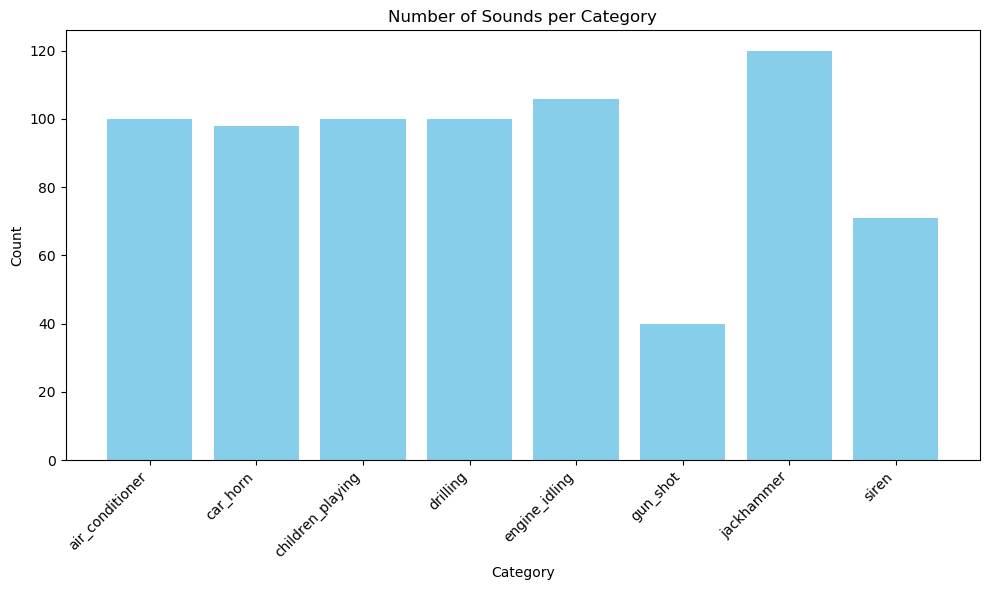

In [7]:
# Plot the counts of each category
category_counts = {category: len(os.listdir(os.path.join(path, category))) for category in categories}
df_counts = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Count'])

plt.figure(figsize=(10, 6))
plt.bar(df_counts['Category'], df_counts['Count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Sounds per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
X_new = df['X'].tolist()
Y_new = df['Y'].tolist()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_new, Y_new, test_size = 0.20, random_state = 44)

In [10]:
precision = []
recall = []
fscore = []
accuracy = []

labels = categories
      
def performance_metrics(algorithm, predict, testY):
    #estY = testY.astype('int')
    #redict = predict.astype('int')
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100 
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+' Accuracy    : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FSCORE      : '+str(f))
    report=classification_report(predict, testY,target_names=labels)
    print('\n',algorithm+" classification report\n",report)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="Blues" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# MLPClassifier

MLPClassifier Accuracy    : 85.03401360544217
MLPClassifier Precision   : 85.08581705387908
MLPClassifier Recall      : 84.86097684341054
MLPClassifier FSCORE      : 84.69345187332993

 MLPClassifier classification report
                   precision    recall  f1-score   support

 air_conditioner       0.95      0.86      0.90        21
        car_horn       0.73      0.84      0.78        19
children_playing       0.57      0.68      0.62        19
        drilling       0.88      0.79      0.83        19
   engine_idling       0.95      0.87      0.91        23
        gun_shot       0.71      0.83      0.77         6
      jackhammer       1.00      0.93      0.96        29
           siren       1.00      1.00      1.00        11

        accuracy                           0.85       147
       macro avg       0.85      0.85      0.85       147
    weighted avg       0.87      0.85      0.86       147



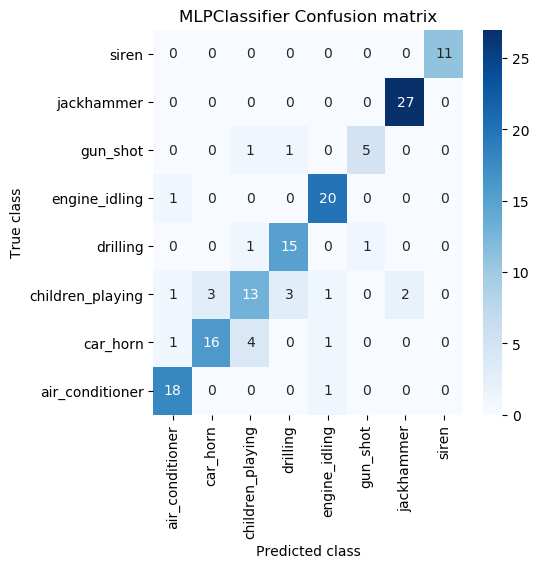

In [11]:
path = 'model/MLPClassifier'
if(os.path.exists(path)):
    mlpc = joblib.load(path) 

else:
    mlpc = MLPClassifier()

y_pred = mlpc.predict(X_test)
performance_metrics('MLPClassifier', y_pred, y_test)

In [12]:
df_resampled = resample(df, replace=True, n_samples=4000, random_state=42)

In [13]:
df_resampled.head()

,X,Y
102,"[-1.1085302829742432, 0.6855318546295166, -0.4...",1
435,"[1.09648597240448, -0.3343718349933624, 1.5534...",4
270,"[0.6604771018028259, 1.010499358177185, -3.010...",2
106,"[0.07562270760536194, 0.29543033242225647, -0....",1
71,"[-1.5356553792953491, 1.426952600479126, -0.25...",0


In [14]:
X_new = df_resampled['X'].tolist()
Y_new = df_resampled['Y'].tolist()

In [15]:
# Create SMOTE object and fit-transform the data
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_new, Y_new)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, Y_resampled, test_size = 0.20, random_state = 44)

In [17]:
precision = []
recall = []
fscore = []
accuracy = []

labels = categories
      
def performance_metrics(algorithm, predict, testY):
    #estY = testY.astype('int')
    #redict = predict.astype('int')
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100 
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+' Accuracy    : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FSCORE      : '+str(f))
    report=classification_report(predict, testY,target_names=labels)
    print('\n',algorithm+" classification report\n",report)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(5, 5)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="Blues" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

# LGBMClassifier

LGBMClassifier Accuracy    : 100.0
LGBMClassifier Precision   : 100.0
LGBMClassifier Recall      : 100.0
LGBMClassifier FSCORE      : 100.0

 LGBMClassifier classification report
                   precision    recall  f1-score   support

 air_conditioner       1.00      1.00      1.00       146
        car_horn       1.00      1.00      1.00       150
children_playing       1.00      1.00      1.00       138
        drilling       1.00      1.00      1.00       137
   engine_idling       1.00      1.00      1.00       148
        gun_shot       1.00      1.00      1.00       143
      jackhammer       1.00      1.00      1.00       114
           siren       1.00      1.00      1.00       127

        accuracy                           1.00      1103
       macro avg       1.00      1.00      1.00      1103
    weighted avg       1.00      1.00      1.00      1103



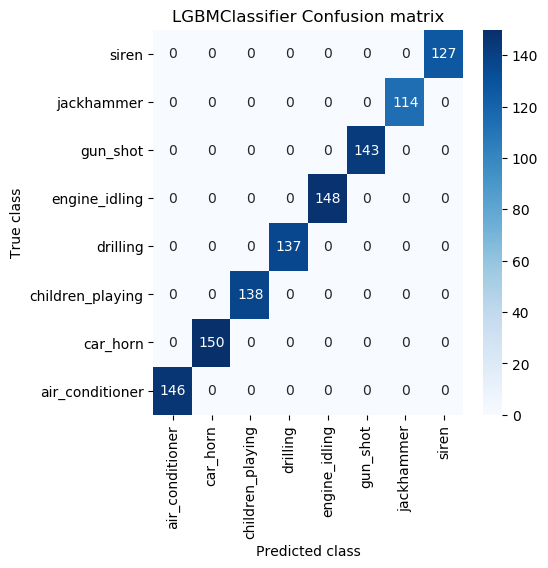

In [18]:
path = 'model/LGBMClassifier'
if(os.path.exists(path)):
    lgbm = joblib.load(path) 

else:
    lgbm = LGBMClassifier()
    lgbm.fit(X_train, y_train)
    joblib.dump(lgbm,path)

y_pred = lgbm.predict(X_test)
performance_metrics('LGBMClassifier', y_pred, y_test)

In [19]:
# prediction on new test data

In [20]:
# Prediction on new test data
def preprocess_audio(audio_path, scaler):
    audio, sr = librosa.load(audio_path, sr=None)
    audio = remove_noise(audio, sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=30)
    features = np.mean(mfccs, axis=1)
    features = scaler.transform([features])  # Normalize features
    return features

In [46]:
audio_path = r"test_data/test1.wav"
X_new = preprocess_audio(audio_path, scaler)
prediction = lgbm.predict(X_new)
predicted_category = categories[prediction[0]]
print(f'Predicted output: {predicted_category}')

Predicted output: car_horn
